In [1]:
from copy import deepcopy
from os import environ
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, make_scorer
from requests import get, Response
from hashlib import sha256
from tqdm.notebook import tqdm
from zipfile import ZipFile
from IPython.display import display, Markdown
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from lightgbm import LGBMClassifier
from lightgbm import LGBMClassifier

import re
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
# Added imports for the new transformer
from scipy import stats
from random import sample

from lightgbm import LGBMClassifier
from utils.image_inverter import save
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV, \
    ParameterGrid
from mlflow import set_tracking_uri, log_metrics, log_figure
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Partie 0 - Constantes, imports et outils

In [2]:
_cache_folder = Path('~/.cache/gn_p7').expanduser()
_cache_folder.mkdir(parents=True, exist_ok=True)

_ds_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip'

graph_folder: Path = Path("./graphs")
random_state: int = 42


def save_figure(figure: plt.Figure, folder: str, figure_name: str) -> None:
    folder = graph_folder / folder
    folder.mkdir(parents=True, exist_ok=True)
    save(figure, folder / f'{figure_name}.png', close=True)


def download(url: str) -> Path:
    url_id: str = sha256(url.encode('utf-8')).hexdigest()
    local_path: Path = _cache_folder / url_id
    local_path.parent.mkdir(parents=True, exist_ok=True)
    if not local_path.exists():
        tmp_path: Path = _cache_folder / (url_id + '.tmp')
        res: Response = get(url, stream=True)
        with tmp_path.open('wb') as f, tqdm(
                total=int(res.headers.get('content-length')),
                desc=f'Downloading {url}',
                unit_scale=True) as q:
            for chunk in res.iter_content(chunk_size=8192):
                q.update(len(chunk))
                f.write(chunk)
        tmp_path.replace(local_path)
    return local_path


def download_zip_archive(url: str) -> Path:
    """Download a zip archive, extract it then return the folder containing its content"""
    archive_path: Path = download(url)
    archive_folder: Path = Path(archive_path.as_posix() + '.dir')

    if not archive_folder.exists():
        print(f'Extracting archive {url}...', flush=True)
        archive_temp: Path = Path(archive_path.as_posix() + '.tmp')
        archive_temp.mkdir(parents=True, exist_ok=True)
        archive: ZipFile = ZipFile(archive_path)
        archive.extractall(path=archive_temp)
        archive_temp.replace(archive_folder)
        print(f'Extracting archive {url}...done', flush=True)

    return archive_folder


datasets: dict[str, pd.DataFrame] = {}


def get_dataset(name: str) -> pd.DataFrame:
    folder = download_zip_archive(_ds_url)
    if not name.endswith('.csv'):
        name = f'{name}.csv'
    try:
        return datasets[name]
    except KeyError:
        try:
            _df = pd.read_csv(folder / name)
        except FileNotFoundError:
            display(Markdown(f'# ERROR: Dataset {name!r} not found, available datasets are:\n' + '\n'.join(
                f'- {p.name}' for p in sorted(folder.iterdir(), key=(lambda x: x.name.lower())))))
            raise KeyError(name) from None
        else:
            datasets[name] = _df
            return _df.copy()


# Partie 1 - EDA

## Partie 1.0 - Chargement des données

In [3]:
from sklearn.model_selection import train_test_split

train, test = map(get_dataset, ('application_train', 'application_test'))
train_ratio = len(train) / (len(train) + len(test))
test_ratio = len(test) / (len(train) + len(test))
train_df, test_df = train, test = train_test_split(
    train,
    test_size=test_ratio,
    random_state=random_state,
    stratify=train['TARGET']
)

In [4]:
# Séparation des features et de la cible
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

print("Données d'entraînement chargées :", X.shape)
print("Cible chargée :", y.shape)

Données d'entraînement chargées : (265436, 121)
Cible chargée : (265436,)


In [5]:
# Séparation des features et de la cible
X = test_df.drop('TARGET', axis=1)
y = test_df['TARGET']

print("Données de test chargées :", X.shape)
print("Cible chargée :", y.shape)

Données de test chargées : (42075, 121)
Cible chargée : (42075,)


In [6]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
270423,413418,0,Cash loans,F,Y,N,1,225000.0,1372500.0,36333.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
217460,351965,0,Cash loans,F,Y,N,2,54000.0,156384.0,16155.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
207043,339985,0,Cash loans,F,N,N,1,166500.0,549882.0,17869.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
51725,159899,0,Cash loans,F,N,Y,0,76500.0,360000.0,17316.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0
221370,356434,0,Revolving loans,F,N,Y,0,247500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5612,106567,0,Cash loans,F,N,Y,0,180000.0,481495.5,32305.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
170183,297241,0,Cash loans,F,N,Y,1,157500.0,846517.5,33700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
31304,136325,0,Revolving loans,F,N,Y,1,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
248504,387513,0,Cash loans,F,N,N,0,90000.0,246357.0,24493.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
test

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
53199,161612,0,Cash loans,F,N,Y,0,112500.0,339241.5,12312.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
285004,430069,1,Revolving loans,F,N,Y,0,135000.0,382500.0,19125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
193019,323834,0,Cash loans,F,N,Y,0,126000.0,356580.0,36666.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
127626,248016,0,Cash loans,M,Y,N,0,225000.0,1812456.0,73948.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
279786,424142,0,Cash loans,M,Y,Y,0,247500.0,640080.0,24259.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61626,171471,0,Cash loans,F,N,Y,0,112500.0,597339.0,33484.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
257802,398333,0,Cash loans,M,N,N,0,112500.0,239850.0,22324.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8285,109660,0,Cash loans,F,N,Y,0,180000.0,521280.0,35392.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
116609,235229,0,Cash loans,F,N,Y,0,157500.0,760225.5,30280.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Partie 1.1 - Analyse de la cible

La cible est présente dans le dataset d'entrainement mais pas dans le dataset de test, pour éviter les fuites de données.

In [8]:
save_figure(train.TARGET.value_counts().plot.pie(
    title='Répartition des cibles (0=paiement complet, 1=retards de paiement)'
).figure, '1_model', '0_target')

## Partie 1.3 - Analyse des features (hors cible)

In [9]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


def missing_stats():
    for fold in ('train', 'test'):
        msno.matrix(get_dataset('application_' + fold + '.csv'), fontsize=12)
        plt.title(f'Missing Values Count ({fold.title()}ing fold)', fontsize=16)
        save_figure(plt.gcf(), '1_model', '1_missing_' + fold.title())

    for fold in ('train', 'test'):
        df = get_dataset('application_' + fold + '.csv')
        msno.matrix(df[list(sorted(df.columns, key=(lambda col: int(df[col].notna().sum()))))], fontsize=12)
        plt.title(f'Missing Values Count ({fold.title()}ing fold)', fontsize=16)
        save_figure(plt.gcf(), '1_model', '2_sorted_missing_' + fold.title())

    for fold in ('train', 'test'):
        missing_test_values = missing_values_table(get_dataset('application_' + fold + '.csv'))

        # TODO: Set the plot style for dark mode when exporting to png
        plt.figure(figsize=(16, 12))  # There are a lot of columns
        sns.barplot(x=missing_test_values['% of Total Values'], y=missing_test_values.index)
        plt.title(f'Percentage of Missing Values by Feature ({fold.title()}ing fold)', fontsize=16)
        plt.xlabel('% of Total Values', fontsize=12)
        plt.ylabel('Features', fontsize=12)

        # Add percentage text on the bars
        for index, value in enumerate(missing_test_values['% of Total Values']):
            plt.text(value, index, f' {value}%', va='center')

        plt.xlim(0, 110)  # Set x-limit to give space for text
        plt.tight_layout()
        save_figure(plt.gcf(), '1_model', '3_graph_missing' + fold.title())


missing_stats()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


Nous pouvons voir qu'à peu près la moitié des colonnes manquent au moins une valeur, et que le reste est défini à environ 45-75%
Si nous nous intéressons

In [10]:
assert not len(train.columns[
                   (train.dtypes != 'int64') &
                   (train.dtypes != 'float64') &
                   (train.dtypes != 'object')]), 'Plus de types de colonnes sont présentes'
display(Markdown('Il existe trois types de données en entrée, int64 et float64, numériques, et object, catégorielles'))
display(
    Markdown('Il arrive parfois que des données numériques soient accidentellement catégorisées en "object" si elles'
             ' contiennent des valeurs non numérique, ce n\'est pas le cas ici'))

Il existe trois types de données en entrée, int64 et float64, numériques, et object, catégorielles

Il arrive parfois que des données numériques soient accidentellement catégorisées en "object" si elles contiennent des valeurs non numérique, ce n'est pas le cas ici

## Partie 2 - Définition du Score Métier

Nous somme face à deux déséquilibres:
- Un déséquilibre des coûts (pb métier) : un faux négatif coûtant dix fois plus cher qu'un faux positif, il faut en tenir compte pour minimiser plus fortement les faux négatifs.
    - Nous devons créer un `scorer` pour Scikit-Learn qui minimise le coût `coût = 10 * FN + 1 * FP`
    - Il doit aussi trouver le seuil de décision optimal, car le seuil par défaut de 0.5 n'est probablement pas le meilleur d'un point de vue métier.
- Un déséquilibre des classes (pb données) : 92% des cibles étant négatives, un risque serai accru d'avoir un modèle prédisant trops 0 (prédire 0 tout le temps nous donnera 92% de précision.
    - Cela sera traité en utilisant comme paramètre `class_weight='balanced'`
    - TODO: Don't forget to include it every time I introduce a new model

In [11]:
def find_optimal_threshold(y_true: np.ndarray, y_pred_proba: np.ndarray):
    """Trouve le seuil qui minimise le coût métier."""
    # Si y_pred_proba est 2D, on prend la probabilité de la classe 1
    if y_pred_proba.ndim == 2:
        y_scores = y_pred_proba[:, 1]
    # Sinon, on suppose que c'est déjà le score pour la classe positive
    else:
        y_scores = y_pred_proba

    thresholds = np.linspace(0.01, 0.99, 100)
    costs = []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)  # On utilise y_scores ici
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        costs.append(10 * fn + 1 * fp)

    optimal_t_index = np.argmin(costs)
    return thresholds[optimal_t_index], costs[optimal_t_index]


def business_cost_scorer_func(y_true: np.ndarray[..., ...], y_pred_proba: np.ndarray[..., ...]):
    """Calcule le coût métier minimal en trouvant le meilleur seuil."""
    _, min_cost = find_optimal_threshold(y_true, y_pred_proba)
    return min_cost / len(y_true)


def optimal_threshold_scorer_func(y_true: np.ndarray[..., ...], y_pred_proba: np.ndarray[..., ...]):
    """Retourne le seuil optimal qui minimise le coût métier."""
    optimal_t, _ = find_optimal_threshold(y_true, y_pred_proba)
    return optimal_t


# Création des scorers pour Scikit-Learn
# On veut MINIMISER le coût, donc greater_is_better=False
business_scorer = make_scorer(business_cost_scorer_func, greater_is_better=False, response_method='predict_proba')

# Pour le seuil, c'est juste une information, donc pas de notion de 'meilleur'
threshold_scorer = make_scorer(optimal_threshold_scorer_func, response_method='predict_proba')

# On définit le dictionnaire de scoring qu'on utilisera dans la cross-validation
scoring = {
    'business_cost': business_scorer,
    'business_threshold': threshold_scorer,
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
print("Scorers métier créés avec succès.")

Scorers métier créés avec succès.


# Partie 3 - Définition d'un pipeline de prétraitement

L'avantage que le pipeline de prétraitement a est la robustesse contrer le data leakage, en effet les modèles d'apprentissages et de traitement seront entraîné sur les mêmes données, ce qui sera obligatoire pour pouvoir utiliser des techniques de K Fold en s'assurant que les folds soient indépendants les uns des autres.

Note: Nous allons ignorer la transformation BoxCox en premier lieu

Note relatives au déséquilibre de la cible:<br>
Il existe un déséquilibre flagrant entre 1 et 0, avec 1 n'étant présent que pour 8% des données d'entraînement.<br>
Pour y remédier, on a a notre disposition:
- oversampling, par exemple SMOT: Synthetic Minority OverSampling Technique
- undersampling
- cost sensitive learning: Ajuster le scoring pour pénaliser davantage les faux négatifs



TODO: Revoir s'il est nécessaire de tester les trois, ou si cost sensitive learning est suffisant


In [12]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

cc = get_dataset('credit_card_balance')
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc_agg


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,False,0.0,0,0.0,False,False,0.0,0,0.0,41
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,False,0.0,0,0.0,False,False,0.0,0,0.0,8
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,95


In [13]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from functools import wraps
from typing import Callable


class OccupationPCA(BaseEstimator, TransformerMixin):
    """
    ORGANIZATION_TYPE et OCCUPATION_TYPE donnent 78 colonnes après OneHot, ce qui complexifie le dataset.
    En théorie cela nous donne 37 colonnes post pca
    Pour minimiser le nombre de features, nous allons procéder de la manière suivante:
    1. Application d'un One-Hot Encoding sur les colonnes 'ORGANIZATION_TYPE' et 'OCCUPATION_TYPE'.
    2. Application d'une ACP pour conserver 95% de la variance, en nommant composantes 'OT_0', 'OT_1', etc.
    5. Suppression des colonnes d'origine et ajout des nouvelles composantes au DataFrame.
    """

    def __init__(self, n_components=0.95):
        self.n_components = n_components  # Will either be a variance or number of components
        self.pca = PCA(n_components=self.n_components)  # This will be "fitted" with the estimator

        # To make sure the dataset holds the same shape, even if some values are missing from the testing dataset
        self.dummy_columns = []

    # TODO: Dummy NA?
    def fit(self, X, y=None):
        x = pd.get_dummies(X[['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']], dummy_na=True)
        self.dummy_columns = x.columns
        self.pca.fit(x)
        return self

    def transform(self, X):
        x = X.copy()
        x_org = pd.get_dummies(x[['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']], dummy_na=True)

        # Add, remove and move around columns to get the same shape as the training set
        x_org = x_org.reindex(columns=self.dummy_columns, fill_value=0)

        pca_result = self.pca.transform(x_org)  # Apply pre-trained PCA

        # Turning the results into a dataframe to include to x
        pca_df = pd.DataFrame(pca_result, columns=[f"OT_{i}" for i in range(pca_result.shape[1])], index=x.index)

        # Replacing old values with new pca values
        return pd.concat([x.drop(columns=['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']), pca_df], axis=1)


class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, handle_unknown='ignore', sparse_output=False):
        self.handle_unknown = handle_unknown
        self.sparse_output = sparse_output
        self.ohe = OneHotEncoder(handle_unknown=self.handle_unknown,
                                 sparse_output=self.sparse_output)

    def fit(self, X, y=None):
        self.categorical_columns_ = X.select_dtypes(include=['object']).columns.tolist()
        if self.categorical_columns_:
            self.ohe.fit(X[self.categorical_columns_])
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if self.categorical_columns_:
            encoded_data = self.ohe.transform(X[self.categorical_columns_])
            new_cols = self.ohe.get_feature_names_out(self.categorical_columns_)
            encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=X.index)
            X_transformed = X_transformed.drop(columns=self.categorical_columns_)
            X_transformed = pd.concat([X_transformed, encoded_df], axis=1)
        return X_transformed


def copy_and_return_x[T, U](callback: Callable[[T, U], None]) -> Callable[[T, U], T]:
    @wraps(callback)
    def wrapped(x: T, y: U = None) -> T:
        callback((x := x.copy()), y)
        return x

    return wrapped


@FunctionTransformer
@copy_and_return_x
def custom_preprocessor(X, y=None) -> None:
    # On commence par réparer l'erreur que nous avons vu à l'étape d'Analyse Exploratoire
    X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].replace({365243: np.nan})

    # On va ensuite supprimer la variable identifiant
    X.pop('SK_ID_CURR')  # TODO: Check for this

    # On va enfin traiter les valeurs catégorielles

    # TODO: Vaut-il mieux utiliser trois colonnes?
    X['CODE_GENDER'] = X['CODE_GENDER'].map({'F': 1, 'M': -1}).fillna(0)

    for flag_name in X.columns[X.columns.str.startswith('FLAG_')]:
        values = set(X[flag_name])
        if {0, 1} - values:
            continue
        if {"Y", "N"} - values:
            X[flag_name] = X[flag_name].map({'Y': 1, 'N': 0})
        else:
            raise RuntimeError(flag_name, values)


@FunctionTransformer
@copy_and_return_x
def sanitize_feature_names(x, y=None):
    x.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in x.columns.tolist()]


# 2. Build the pipeline
preprocessing_pipeline = Pipeline([
    ('custom_preprocessor', custom_preprocessor),
    ('occupation_pca', OccupationPCA()),
    ('first_name_sanitization', deepcopy(sanitize_feature_names)),
    ('dummy_preprocessor', CategoricalEncoder(handle_unknown='ignore', sparse_output=False)),
    ('second_name_sanitization', deepcopy(sanitize_feature_names)),
], verbose=True)

# We try to see if the pipeline works as expected
X_train = train.copy()
y_train = X_train.pop('TARGET')
deepcopy(preprocessing_pipeline).fit_transform(X_train, y_train)

[Pipeline]  (step 1 of 5) Processing custom_preprocessor, total=   0.8s
[Pipeline] .... (step 2 of 5) Processing occupation_pca, total=   0.5s
[Pipeline]  (step 3 of 5) Processing first_name_sanitization, total=   0.1s
[Pipeline]  (step 4 of 5) Processing dummy_preprocessor, total=   0.6s
[Pipeline]  (step 5 of 5) Processing second_name_sanitization, total=   0.1s


,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
270423,1.0,1,225000.0,1372500.0,36333.0,1372500.0,0.024610,-18406,-4668.0,-929.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
217460,1.0,2,54000.0,156384.0,16155.0,135000.0,0.018634,-14394,-1187.0,-1044.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
207043,1.0,1,166500.0,549882.0,17869.5,459000.0,0.032561,-13951,-544.0,-7348.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
51725,1.0,0,76500.0,360000.0,17316.0,360000.0,0.035792,-22683,NaN,-8123.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
221370,1.0,0,247500.0,135000.0,6750.0,135000.0,0.008230,-15790,-193.0,-542.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5612,1.0,0,180000.0,481495.5,32305.5,454500.0,0.019101,-19605,-12927.0,-9997.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
170183,1.0,1,157500.0,846517.5,33700.5,684000.0,0.035792,-14742,-7799.0,-5732.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
31304,1.0,1,135000.0,405000.0,20250.0,405000.0,0.035792,-15374,-595.0,-6831.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
248504,1.0,0,90000.0,246357.0,24493.5,234000.0,0.025164,-23088,NaN,-8975.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Partie 4: Outils

In [14]:
# TODO: Danger of this, if values are negatives and test values are smaller than train values, offset won't be enough
# I don't want the BoxCox transformer to mess up data that it cannot fix.
# TODO: Review how I estimate if it's worth the transformation
epsilon = 1e-6


class ConditionalBoxCox(BaseEstimator, TransformerMixin):

    def __init__(self, p_value_threshold: float = 0.05):
        self.p_value_threshold = p_value_threshold
        self.columns_to_transform_ = []
        self.learned = {}

    def _as_numpy(self, X: pd.DataFrame | np.ndarray[tuple[int, ...], np.dtype[np.float64]]):
        x: np.ndarray
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if X[col].isna().any():
                    raise NotImplementedError(
                        'I do not know yet how this would be handled,\n\t'
                        'for now, you need this to follow an inputer to have no null values')
            columns_to_drop = [i for i in X.columns if X[i].dtype == 'object']
            columns_to_keep = [i for i in X.columns if X[i].dtype in ('float64', 'int64')]
            if len(other_columns := set(X.columns) - set(columns_to_keep) - set(columns_to_drop)):
                raise NotImplementedError(other_columns)
            x = X.to_numpy()
        elif isinstance(X, np.ndarray):
            x = X
        else:
            raise NotImplementedError(type(X))
        return x

    # noinspection PyTypeHints
    def fit(self, X: pd.DataFrame | np.ndarray[tuple[int, ...], np.dtype[np.float64]], y=None):
        x = self._as_numpy(X.copy())

        for col, data in enumerate(x.T):
            if len(set(data)) < 10:  # Not worth the change
                continue
            data = data + (shift := epsilon - (0 if (data > 0).all() else data.min()))
            _, initial_p = stats.shapiro(sample(list(data), 100))
            transformed_data, ld = stats.boxcox(data)
            _, transformed_p = stats.shapiro(sample(list(transformed_data), 100))
            if transformed_p > initial_p and transformed_p > self.p_value_threshold:
                self.columns_to_transform_.append(col)
                self.learned[col] = ld, shift
        return self

    def transform(self, X):
        x = self._as_numpy(X.copy())
        for index in self.columns_to_transform_:
            ld, shift = self.learned[index]
            x[:, index] = stats.boxcox(
                x[:, index] + shift, lmbda=ld)
        return x


def new_pipeline(*steps):
    return Pipeline(deepcopy(preprocessing_pipeline.steps) + list(steps))

## Partie 5: Pipelines de modélisation

Nous allons maintenant définir nos modèles et lancer les expérimentations. Chaque modèle sera testé dans un `run` MLflow distinct.

Pour chaque `run`, nous allons logger :
1.  **Les paramètres** : Tous les hyperparamètres du pipeline.
2.  **Les métriques** : Les scores (AUC, coût métier, seuil) calculés par validation croisée (moyenne et écart-type).
3.  **Le modèle final** : Le pipeline complet, entraîné sur l'ensemble des données, prêt à être déployé.
4.  **(Optionnel) Des artefacts** : Comme des graphiques (ex: feature importance).

In [15]:
from mlflow import set_experiment, start_run, log_params, log_metric, log_metrics, sklearn, models, set_tag
from sklearn.model_selection import ParameterGrid
from copy import deepcopy
import numpy as np

# --- 1. Configuration et Préparation ---

# Définition des modèles de prétraitement
pipelines = [
    ('DummyClassifier', new_pipeline(('model', DummyClassifier(strategy='stratified'))), {}),
    ('LogisticRegression', new_pipeline(
        ('imputer', SimpleImputer()),
        ('coxbox', ConditionalBoxCox()),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced'))), {
         'model__C': [0.1, 1.0, 10.0], 'model__max_iter': [100, 1000]}),
    ('LightGBMClassifier', new_pipeline(('model', LGBMClassifier(class_weight='balanced'))), {
        'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__num_leaves': [20, 31]})
]
pipelines = [
    ('LightGBMClassifier', new_pipeline(('model', LGBMClassifier(class_weight='balanced'))), {
        'model__n_estimators': [100], 'model__learning_rate': [0.05], 'model__num_leaves': [20]})
]

# Définition de la stratégie de validation croisée
cv_strategy = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=random_state)

# Préparation des données
X_train = train.copy()
y_train = X_train.pop('TARGET')

display(Markdown(f"***{len(pipelines)}*** types de modèles sont prêts à être testés."))

# Configuration de MLflow
set_tracking_uri('http://127.65.12.247:50222')
set_experiment("P7_Credit_Scoring_Models")

# Variables pour suivre le meilleur modèle sur l'ensemble des expérimentations
best_global_score = -float('inf')  # On maximise le score (qui est un coût négatif)
best_global_model_name = ""
best_global_pipeline_base = None
best_global_params = {}

# Boucle sur chaque type de modèle (Dummy, LogisticRegression, LightGBM)
for model_name, pipeline_base, grid_params in pipelines:
    print(f"\n--- Lancement de l'expérimentation pour le modèle : {model_name} ---")

    # On crée un "run parent" pour regrouper tous les tests d'hyperparamètres de ce modèle
    with start_run(run_name=f"{model_name}_Hyperparameter_Search") as parent_run:
        set_tag("model_type", model_name)

        grid = list(ParameterGrid(grid_params)) or [{}]

        # Variables pour suivre le meilleur run localement (pour ce type de modèle)
        best_local_score = -float('inf')
        best_local_params = {}

        # Boucle sur chaque combinaison d'hyper paramètres
        for parameters_index, parameters_data in enumerate(grid):

            # Pour chaque jeu de paramètres, on crée un "run enfant" imbriqué
            # C'est la correction clé : chaque test a son propre run !
            with start_run(run_name=f"run_{parameters_index + 1}", nested=True) as child_run:
                print(f"  > Test des paramètres : {parameters_data}")

                # 1. Log des paramètres (une seule fois par run enfant)
                log_params(parameters_data)

                pipeline = deepcopy(pipeline_base)
                pipeline.set_params(**parameters_data)

                # 2. Cross-validation
                cv_results = cross_validate(
                    estimator=pipeline,
                    X=X_train,
                    y=y_train,
                    cv=cv_strategy,
                    scoring=scoring,
                    n_jobs=-1,
                    return_train_score=False
                )

                # 3. Log des métriques résumées dans le run enfant
                summary_metrics = {}
                for scorer_name in scoring.keys():
                    mean_score = np.mean(cv_results[f'test_{scorer_name}'])
                    std_score = np.std(cv_results[f'test_{scorer_name}'])
                    summary_metrics[f'mean_{scorer_name}'] = mean_score
                    summary_metrics[f'std_{scorer_name}'] = std_score

                summary_metrics['mean_fit_time'] = np.mean(cv_results['fit_time'])
                log_metrics(summary_metrics)

                # 4. Suivi du meilleur score local
                current_score = summary_metrics['mean_business_cost']
                if current_score > best_local_score:
                    best_local_score = current_score
                    best_local_params = parameters_data

        # 5. Une fois tous les hyper paramètres testés, on met à jour le run parent avec le meilleur résultat
        log_metric("best_mean_business_cost", best_local_score, run_id=parent_run.info.run_id)
        log_params(best_local_params, run_id=parent_run.info.run_id)

        # 6. Mise à jour du meilleur score global
        if best_local_score > best_global_score:
            print(f"  > Nouveau meilleur modèle GLOBAL trouvé : {model_name} avec un coût de {-best_local_score:.2f}")
            best_global_score = best_local_score
            best_global_model_name = model_name
            best_global_pipeline_base = pipeline_base
            best_global_params = best_local_params

print("\n\n--- FIN DE LA RECHERCHE D'HYPERPARAMÈTRES ---")
print(f"Le meilleur modèle global est : '{best_global_model_name}'")
print(f"Avec les hyperparamètres : {best_global_params}")
# On affiche le coût en positif pour la lisibilité
print(f"Son coût métier moyen par validation croisée est de : {-best_global_score:.2f}")

# --- 3. Entraînement et enregistrement du modèle champion ---
# Cette partie est maintenant plus claire : on prend le meilleur pipeline et on l'entraîne une dernière fois
print("\n--- Entraînement final et enregistrement du modèle champion ---")

if best_global_pipeline_base:
    # On crée un dernier run dédié au modèle final
    with start_run(run_name=f"{best_global_model_name}_champion") as champion_run:
        print(f"Création d'un run final pour le champion : {champion_run.info.run_name}")

        # On loggue ses meilleurs paramètres et son score
        log_params(best_global_params)
        log_metric("final_cv_business_cost", -best_global_score)  # On log le coût positif
        set_tag("model_status", "champion")

        # On configure le pipeline final avec les meilleurs paramètres
        champion_pipeline = deepcopy(best_global_pipeline_base)
        champion_pipeline.set_params(**best_global_params)

        # On l'entraîne sur TOUTES les données d'entraînement
        champion_pipeline.fit(X_train, y_train)

        # On loggue le modèle entraîné dans MLflow pour pouvoir le réutiliser plus tard
        X_test_sample = test.drop('TARGET', axis=1).head()
        signature = models.infer_signature(X_test_sample, champion_pipeline.predict_proba(X_test_sample))

        sklearn.log_model(
            sk_model=champion_pipeline,
            artifact_path="model",
            signature=signature,
            registered_model_name=f"{best_global_model_name}_champion_model"
        )
        print("Modèle champion entraîné et enregistré dans le Model Registry de MLflow.")

        # On stocke le meilleur pipeline pour les cellules suivantes (par ex. pour SHAP)
        best_model = champion_pipeline

else:
    print("Aucun modèle n'a été entraîné avec succès.")

***1*** types de modèles sont prêts à être testés.


--- Lancement de l'expérimentation pour le modèle : LightGBMClassifier ---
  > Test des paramètres : {'model__learning_rate': 0.05, 'model__n_estimators': 100, 'model__num_leaves': 20}
[LightGBM] [Info] Number of positive: 18367, number of negative: 209149
[LightGBM] [Info] Number of positive: 18367, number of negative: 209149
[LightGBM] [Info] Number of positive: 18367, number of negative: 209150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.124434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19801
[LightGBM] [Info] Number of data points in the train set: 227516, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 18367, number of negative: 209150
[LightGBM] [Info] Number of positive: 

/home/nadir/Projects/p7.13.env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/08/25 00:06:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'LightGBMClassifier_champion_model' already exists. Creating a new version of this model...
2025/08/25 0

Modèle champion entraîné et enregistré dans le Model Registry de MLflow.
🏃 View run LightGBMClassifier_champion at: http://127.65.12.247:50222/#/experiments/766270891001601525/runs/2ca921286a184954bfed7eefe6e76c2d
🧪 View experiment at: http://127.65.12.247:50222/#/experiments/766270891001601525


Created version '2' of model 'LightGBMClassifier_champion_model'.


[LightGBM] [Info] Number of positive: 21428, number of negative: 244008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19791
[LightGBM] [Info] Number of data points in the train set: 265436, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


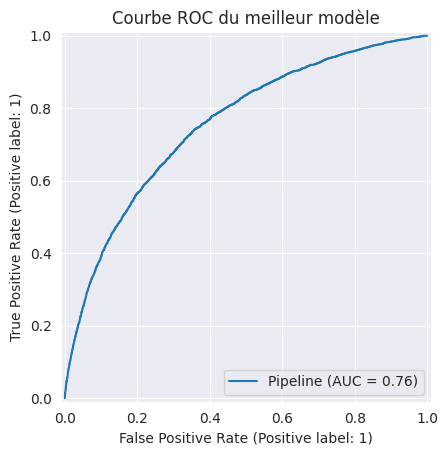

In [16]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
X_train = train.copy()
y_train = X_train.pop('TARGET')
best_model.fit(X_train, y_train)
X_test = test.copy()
y_test = X_test.pop('TARGET')
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
plt.title("Courbe ROC du meilleur modèle")

# Sauvegarde la figure en tant qu'artefact MLflow
log_figure(fig, "roc_curve.png")

plt.show()

In [17]:
import mlflow
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score, accuracy_score, f1_score
from mlflow import end_run

# TODO: Why this?
end_run()

# --- 1. Récupération du modèle champion et du run MLflow associé ---
# On suppose que la cellule précédente a déjà entraîné et stocké le meilleur modèle
# dans la variable 'best_model'.
# On récupère les informations du dernier run "CHAMPION" qui a été créé.
champion_run = mlflow.last_active_run()
run_id = champion_run.info.run_id
print(f"Analyse du modèle champion depuis le run MLflow ID: {run_id}")

# --- 2. Préparation des données de test ---
# Utilisons les variables train_df/test_df que vous avez créées au début avec train_test_split.
# (Rappel : il faudra adapter ceci après l'ajout du feature engineering)
X_test_final = test_df.drop('TARGET', axis=1)
y_test_final = test_df['TARGET']

# --- 3. Évaluation sur le jeu de test et logging des métriques ---
print("Évaluation sur le jeu de test...")
y_pred_proba_test = best_model.predict_proba(X_test_final)

# On utilise la fonction 'find_optimal_threshold' que vous avez définie plus haut
optimal_threshold_test, business_cost_test = find_optimal_threshold(y_test_final, y_pred_proba_test)
y_pred_class_test = (y_pred_proba_test[:, 1] >= optimal_threshold_test).astype(int)

test_metrics = {
    "test_business_cost": business_cost_test,
    "test_optimal_threshold": optimal_threshold_test,
    "test_roc_auc": roc_auc_score(y_test_final, y_pred_proba_test[:, 1]),
    "test_accuracy_at_threshold": accuracy_score(y_test_final, y_pred_class_test),
    "test_f1_at_threshold": f1_score(y_test_final, y_pred_class_test)
}

# On loggue les métriques DANS LE RUN EXISTANT
with mlflow.start_run(run_id=run_id):
    mlflow.log_metrics(test_metrics)
    print("Métriques de test ajoutées au run champion.")

    # --- 4. Logging des artefacts (graphiques) ---
    # Matrice de confusion
    fig_cm, ax_cm = plt.subplots()
    cm = confusion_matrix(y_test_final, y_pred_class_test)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax_cm, cmap='Blues')
    ax_cm.set_title(f'Matrice de Confusion (Seuil = {optimal_threshold_test:.2f})')
    mlflow.log_figure(fig_cm, "test_confusion_matrix.png")
    plt.close(fig_cm)

    # Courbe ROC
    fig_roc, ax_roc = plt.subplots()
    RocCurveDisplay.from_estimator(best_model, X_test_final, y_test_final, ax=ax_roc)
    ax_roc.set_title("Courbe ROC sur jeu de test")
    mlflow.log_figure(fig_roc, "test_roc_curve.png")
    plt.close(fig_roc)
    print("Graphiques (matrice de confusion, courbe ROC) ajoutés au run champion.")

    # --- 5. Analyse SHAP ---
    print("Calcul des valeurs SHAP...")
    preprocessor = best_model[:-1]
    model_step = best_model.named_steps['model']

    # On utilise un échantillon pour la rapidité
    X_test_sample = X_test_final # .sample(n=1000, random_state=random_state)
    X_test_transformed = preprocessor.transform(X_test_sample)
    X_test_transformed.columns = [str(col) for col in X_test_transformed.columns]

    explainer = None
    if 'LGBMClassifier' in str(type(model_step)):
        explainer = shap.TreeExplainer(model_step)
    elif 'LogisticRegression' in str(type(model_step)):
        explainer = shap.LinearExplainer(model_step, X_test_transformed)

    if explainer:
        shap_values = explainer(X_test_transformed)
        shap.summary_plot(shap_values, X_test_transformed, show=False, max_display=20, plot_type="bar")
        plt.title("Importance globale des features (SHAP) sur le jeu de test")
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), "test_shap_summary_bar.png")
        plt.close()
        print("Graphique SHAP ajouté au run champion.")

print("\n--- ANALYSE TERMINÉE ---")
print(f"Le run {run_id} a été mis à jour avec les analyses sur le jeu de test.")

🏃 View run angry-gnat-126 at: http://127.65.12.247:50222/#/experiments/766270891001601525/runs/2011d12bfec140a89e44f6ead7214c10
🧪 View experiment at: http://127.65.12.247:50222/#/experiments/766270891001601525
Analyse du modèle champion depuis le run MLflow ID: 2011d12bfec140a89e44f6ead7214c10
Évaluation sur le jeu de test...
Métriques de test ajoutées au run champion.
Graphiques (matrice de confusion, courbe ROC) ajoutés au run champion.
Calcul des valeurs SHAP...
Graphique SHAP ajouté au run champion.
🏃 View run angry-gnat-126 at: http://127.65.12.247:50222/#/experiments/766270891001601525/runs/2011d12bfec140a89e44f6ead7214c10
🧪 View experiment at: http://127.65.12.247:50222/#/experiments/766270891001601525

--- ANALYSE TERMINÉE ---
Le run 2011d12bfec140a89e44f6ead7214c10 a été mis à jour avec les analyses sur le jeu de test.


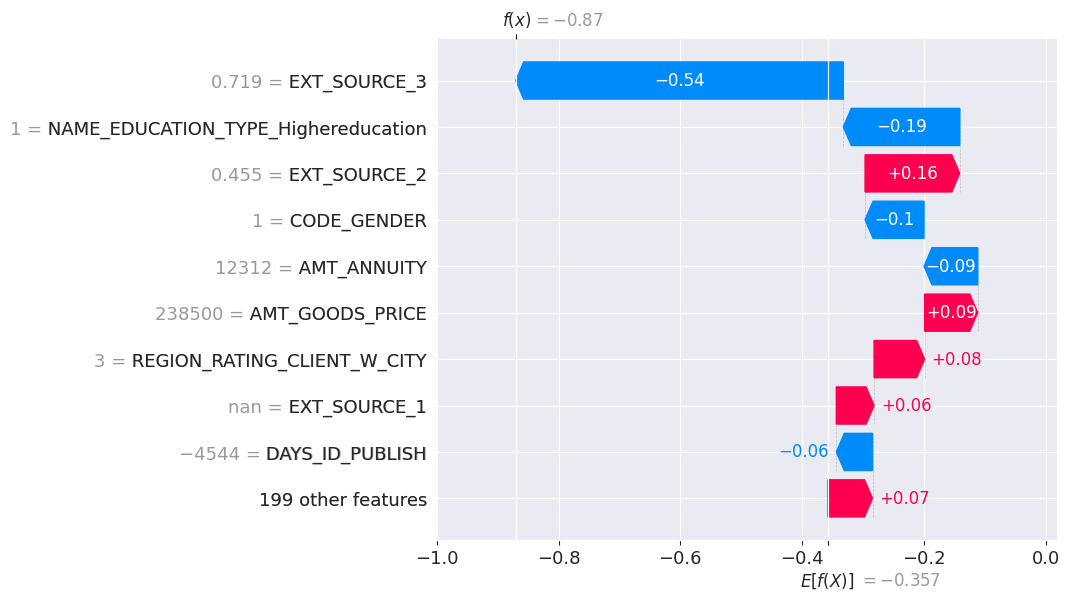

In [18]:
# 'explainer' et 'X_test_transformed' sont déjà calculés dans ton code
# Choisissons un client à expliquer (par exemple le premier)
client_index = 0
shap_values_client = explainer(X_test_transformed.iloc[[client_index]])

# Pour un graphique en "cascade" (très visuel)
shap.waterfall_plot(shap_values_client[0])

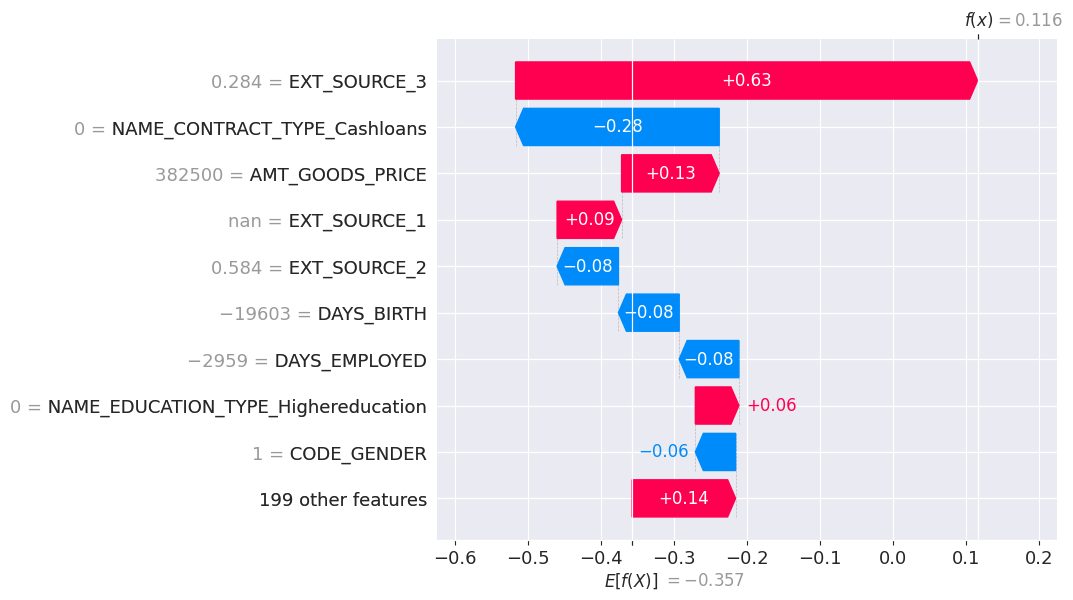

In [28]:
# 'explainer' et 'X_test_transformed' sont déjà calculés dans ton code
# Choisissons un client à expliquer (par exemple le premier)
client_index = 1
shap_values_client = explainer(X_test_transformed.iloc[[client_index]])

# Pour un graphique en "cascade" (très visuel)
shap.waterfall_plot(shap_values_client[0])

In [27]:
y_test_final.iloc[[2]]

193019    0
Name: TARGET, dtype: int64

In [19]:
# --- 6. Analyse SHAP Locale (pour un client) ---
print("Analyse de l'importance locale pour un client spécifique...")

# Sélectionnons un client du jeu de test (par exemple, le premier)
client_index = 0
client_data = X_test_final.iloc[[client_index]]
client_transformed = preprocessor.transform(client_data)
client_transformed.columns = [str(col) for col in client_transformed.columns]

# Calculer les valeurs SHAP pour ce client
shap_values_client = explainer(client_transformed)

# Afficher la prédiction et la probabilité
proba_client = best_model.predict_proba(client_data)[0][1]
decision_client = "Refusé" if proba_client >= optimal_threshold_test else "Accepté"
print(f"\\nClient ID: {client_data.index[0]}")
print(f"Probabilité de défaut: {proba_client:.2f} (Seuil: {optimal_threshold_test:.2f}) -> Décision: {decision_client}")

# Créer le graphique force_plot
# Il montre comment chaque feature pousse la prédiction de la valeur de base (moyenne) vers la prédiction finale.
shap.force_plot(
    explainer.expected_value[1],  # La valeur de base pour la classe 1
    shap_values_client.values[:,:,1], # Les valeurs SHAP pour la classe 1
    client_transformed,
    matplotlib=True,
    show=False
)
plt.title(f"Analyse SHAP locale pour le client {client_data.index[0]}")
plt.tight_layout()

# Logguer la figure dans MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_figure(plt.gcf(), f"local_shap_force_plot_client_{client_data.index[0]}.png")

plt.show()

# Créer le graphique waterfall_plot (encore plus clair)
shap.waterfall_plot(shap_values_client[0,:,1], max_display=15)

Analyse de l'importance locale pour un client spécifique...
\nClient ID: 53199
Probabilité de défaut: 0.30 (Seuil: 0.53) -> Décision: Accepté


IndexError: invalid index to scalar variable.

In [ ]:
import json
from pathlib import Path
import pandas as pd

print("--- Génération du fichier de données JSON pour les tests unitaires ---")

# 1. Définir le chemin de sortie
output_path = Path("api/tests/test_api.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

# 2. Sélectionner un client exemple depuis le jeu de test
# On prend le premier client pour la reproductibilité
client_sample_series = test_df.drop('TARGET', axis=1).iloc[0]

# 3. Convertir en dictionnaire et nettoyer pour la sérialisation JSON
# Remplacer les NaN par None, ce qui est le standard JSON pour 'null'
payload_dict = client_sample_series.to_dict()
payload_cleaned = {k: (None if pd.isna(v) else v) for k, v in payload_dict.items()}

# 4. Écrire le dictionnaire dans le fichier JSON
with output_path.open('w', encoding='utf-8') as f:
    json.dump(payload_cleaned, f, indent=4)

print(f"✅ Fichier de données de test sauvegardé avec succès dans : {output_path}")
print(f"Le client SK_ID_CURR = {int(payload_cleaned['SK_ID_CURR'])} sera utilisé pour les tests.")

## Partie 4 - Analyse des Résultats et Prochaines Étapes

Toutes nos expérimentations sont maintenant enregistrées. Pour les visualiser, lance l'interface utilisateur de MLflow via "http://127.65.12.247:50222"


Dans l'interface, tu pourras :
- **Comparer les modèles** en les sélectionnant et en cliquant sur "Compare".
- **Trier les runs** par `business_cost_mean` (le score le plus bas est le meilleur) ou `roc_auc_mean`.
- **Inspecter chaque run** pour voir les paramètres exacts qui ont produit un certain résultat.

### Prochaines étapes basées sur ces résultats :

1.  **Choisir le meilleur modèle** : Sur la base du score métier, sélectionne le modèle le plus prometteur (probablement LightGBM).
2.  **Optimisation des hyperparamètres** : Pour le modèle choisi, tu pourras lancer une nouvelle série d'expérimentations (par exemple avec `GridSearchCV` ou `Hyperopt`) pour trouver les meilleurs hyperparamètres, toujours en optimisant le score métier. Chaque essai de la recherche d'hyperparamètres peut être un `run` MLflow imbriqué !
3.  **Analyse de l'importance des features** : Une fois le modèle finalisé, utilise des librairies comme **SHAP** pour analyser l'importance des features globale et locale, comme demandé dans le brief.
4.  **Enregistrement du modèle final** : Le meilleur run pourra être promu dans le "Model Registry" de MLflow, lui donnant un statut (Staging, Production) pour le déploiement.